# Imports

In [2]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
from tqdm import tqdm
import statsmodels.formula.api as smf
import pandas as pd

/Users/o.weisse/switchback_test_dag/venv/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


# Download Data

In [3]:
client = bigquery.Client(project = 'logistics-data-staging-flat')

In [4]:
test_name = 'CL_20230428_R_B0_O_AntofagastaClusteringStrategy'
test_name = "TH_20220721_R_F0_O_Switchback_AA_Test_Trang"
start_date = "2022-07-20"
end_date = "2022-08-18"

In [5]:
query = f"""
SELECT 
        -- Identifiers and supplementary fields     
        -- Date and time
        a.created_date AS created_date_utc,
        a.order_placed_at,

        -- Location of order
        a.region,
        a.entity_id,
        a.country_code,
        a.city_name,
        a.city_id,
        a.zone_name,
        a.zone_id,

        -- Order/customer identifiers and session data
        a.variant,
        a.experiment_id AS test_id,
        b.test_name,
        a.platform_order_code,
        a.order_id,
        a.scheme_id,
        a.vendor_price_scheme_type,	-- The assignment type of the scheme to the vendor during the time of the order, such as "Automatic", "Manual", "Campaign", and "Country Fallback".
        
        --KPIs that we want to measure
        orders.rider.timings.actual_delivery_time/60 delivery_time,
        orders.rider.timings.order_delay/60 order_delay,
        --orders.rider.deliveries.dropoff_distance_dte distance
        
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` a
    LEFT JOIN `fulfillment-dwh-production.cl.dps_ab_test_orders_v2` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
    LEFT JOIN `fulfillment-dwh-production.cl.orders_v2` orders ON a.entity_id = orders.entity_id AND a.platform_order_code = orders.global_order_id
    WHERE TRUE
        AND a.created_date BETWEEN DATE("{start_date}") AND DATE("{end_date}")
        AND b.test_name = "{test_name}" -- Search for relevant tests
        AND a.is_sent -- Successful orders
        AND a.is_own_delivery -- OD orders only
        AND a.variant != "Original" -- Exclude orders from ASAs
        AND a.is_match_experiment_vertical -- Filter for sessions where the parent vertical of the vendor matches the
"""

In [6]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client

data = client.query(query).result()\
    .to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/158911 [00:00<?, ?rows/s]

In [7]:
data = data[data['delivery_time']<120]

<AxesSubplot:xlabel='delivery_time', ylabel='Density'>

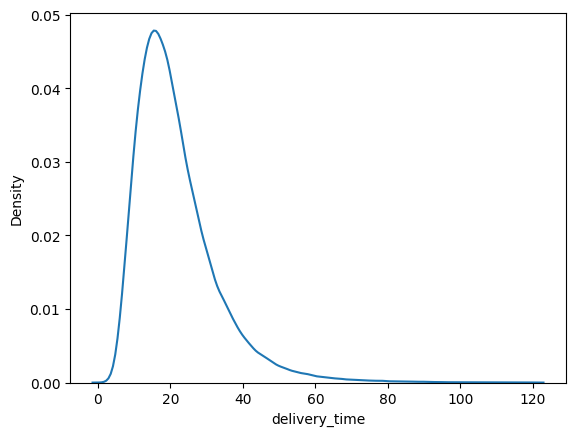

In [9]:
sns.kdeplot(data['delivery_time'])

# Implement different methods for significance

In [10]:
def randomize_time_unit_assignment(data):
    """Creates a new columns called 'group'. Assigns each time unit randomly to either group A or B."""
    time_unit_group_dict = {i: np.random.choice(['A', 'B']) for i in data.time_unit.unique()}
    data['group'] = data['time_unit'].map(time_unit_group_dict)

In [11]:
def naive_order_level_significane(data, KPI_A, KPI_B, threshold=0):
    """Uses a ttest on order level to check for significance."""
    _, p, _ = ttest_ind(data[data['group']=='A'][KPI_A], data[data['group']=='B'][KPI_B])
    if p < 0.05:
        return True

In [12]:
def time_unit_significance(data, KPI_A, KPI_B, threshold=0):
    """Aggregates the data on time unit and then uses a ttest on this aggregated data."""
    A = data[data['group']=='A'].groupby('time_unit')[KPI_A].mean()
    B = data[data['group']=='B'].groupby('time_unit')[KPI_B].mean()
    _, p, _ = ttest_ind(A, B)
    if p < 0.05:
        return True

In [13]:
def get_adjusted_p_value_threshold(data, KPI, n_iterations=1000, p=5):
    """Calculates the significance threshold for the adusted p-value method."""
    measured_effects = []
    for i in range(n_iterations):
        randomize_time_unit_assignment(data)
        measured_effect = data[data['group']=='A'][KPI].mean()-data[data['group']=='B'][KPI].mean()
        measured_effects.append(measured_effect)
    lower_threshold = np.percentile(measured_effects, p/2)
    upper_threshold = np.percentile(measured_effects, 100-p/2)
    threshold = np.max([lower_threshold, upper_threshold])
    return threshold

In [14]:
def adjusted_p_value_significance(data, KPI_A, KPI_B, threshold):
    """Calculates the adjusted p-value and then checks for significance."""
    difference = data[data['group']=='A'][KPI_A].mean() - data[data['group']=='B'][KPI_B].mean()
    if abs(difference) > threshold:
        return True

In [15]:
def CRSE_significance(data, KPI_A, KPI_B, threshold=0):
    """Uses the cluster robust standard error method to check for significance."""
    data["group_binary"] = data['group'].map({"A":0, "B": 1})
    data['KPI'] = np.where(data['group']=="A", data[KPI_A], data[KPI_B])
    model = smf.ols(formula=f'KPI ~ group_binary', data=data)
    p = model.fit(cov_type="cluster", cov_kwds={'groups': data['time_unit']}).pvalues["group_binary"]
    if p < 0.05:
        return True

# FPR and power evaluation functions

In [16]:
def FPR(data, KPI, check_significance, n_iterations=1000, threshold = 0):
    """Calculates the false positive rate for one of the above significance tests."""
    effect_found = 0
    for i in range(n_iterations):
        randomize_time_unit_assignment(data)
        if check_significance(data, KPI, KPI, threshold):
            effect_found += 1
    return effect_found/n_iterations

In [17]:
def power(data, KPI, effect_size, check_significance, n_iterations, threshold=0):
    """Calculates the power for one of the above significance tests."""
    effect_found = 0
    for i in range(n_iterations):
        randomize_time_unit_assignment(data)
        data[KPI+"_simulated"] = data[KPI]+effect_size
        if check_significance(data, KPI, KPI+"_simulated", threshold):
            effect_found += 1
    return effect_found/n_iterations

# Power comparison graph

In [18]:
class percentage_metric:
    """Percentage metric is a single float value and has an uncertainty according to the standard error of
    the mean of a bernoulli distributed variable."""
    def __init__(self, value, N):
        self.value = value
        self.unc = 2*np.sqrt(value*(1-value)/N)
        
    def __repr__(self):
        return str(self.value)+'+-'+str(self.unc)

In [19]:
def evaluate_test(metric, KPI, check_significance, window_sizes, effect_size, n_iterations):
    """Calculates FPR or power for different specified window sizes."""
    metrics = []
    threshold = 0
    for window_size in tqdm(window_sizes):
        data['time_unit'] = data['order_placed_at'].dt.floor(window_size)
        if check_significance == adjusted_p_value_significance:
            threshold = get_adjusted_p_value_threshold(data, "delivery_time", n_iterations=500, p=5)
        
        if metric == power:
            metric_value = power(data, KPI, effect_size, check_significance, n_iterations, threshold)
        elif metric == FPR:
            metric_value = FPR(data, KPI, check_significance, n_iterations, threshold)
            
        metrics.append(percentage_metric(metric_value, n_iterations))
        
    name = check_significance.__name__
    return pd.Series(metrics, index=window_sizes, name=name)

In [20]:
window_sizes = [str(i)+"H" for i in range(1,12)]+["1D", "2D", "3D"]
# window_sizes = ["1D", "2D", "3D"]
window_sizes

['1H',
 '2H',
 '3H',
 '4H',
 '5H',
 '6H',
 '7H',
 '8H',
 '9H',
 '10H',
 '11H',
 '1D',
 '2D',
 '3D']

In [21]:
results = pd.DataFrame()
for check_significance in [naive_order_level_significane, time_unit_significance,
                          adjusted_p_value_significance, CRSE_significance]:
    powers = evaluate_test(power, "delivery_time", check_significance, window_sizes, 1, 100)
    results[powers.name] = powers

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [23:34<00:00, 101.04s/it]


Text(0.5, 1.0, 'power for an effect of 1 min. DT for different window sizes')

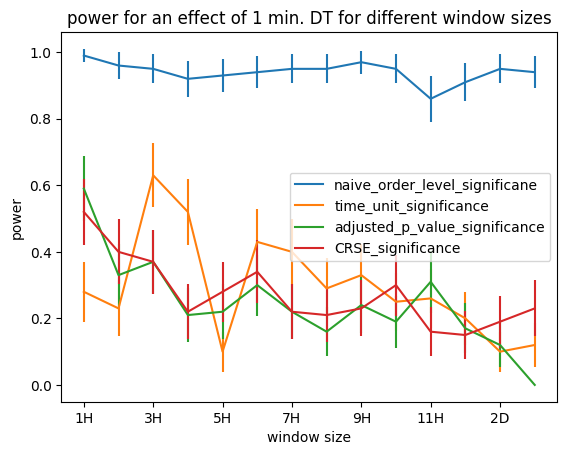

In [22]:
results.applymap(lambda x: x.value).plot(yerr=results.applymap(lambda x: x.unc))
plt.ylabel("power")
plt.xlabel("window size")
plt.title("power for an effect of 1 min. DT for different window sizes")

# FPR comparison graph

In [23]:
results = pd.DataFrame()
for check_significance in [naive_order_level_significane, time_unit_significance,
                          adjusted_p_value_significance, CRSE_significance]:
    powers = evaluate_test(FPR, "delivery_time", check_significance, window_sizes, 1, 100)
    results[powers.name] = powers

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [23:31<00:00, 100.83s/it]


Text(0.5, 1.0, 'FPR for different window sizes')

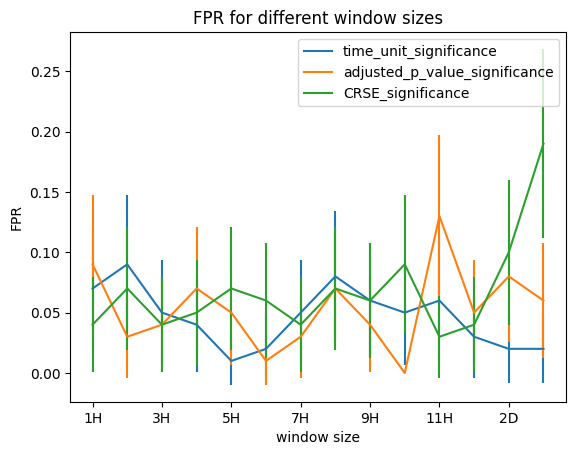

In [24]:
results.drop('naive_order_level_significane', axis=1).applymap(
    lambda x: x.value).plot(yerr=results.applymap(lambda x: x.unc))

plt.ylabel("FPR")
plt.xlabel("window size")
plt.title("FPR for different window sizes")

In [25]:
results.applymap(lambda x: x.value).mean()

naive_order_level_significane    0.907143
time_unit_significance           0.046429
adjusted_p_value_significance    0.053571
CRSE_significance                0.067857
dtype: float64

Text(0.5, 1.0, 'FPR for different window sizes')

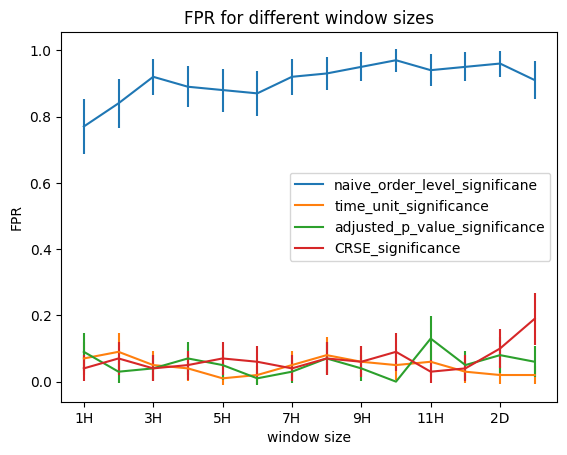

In [26]:
results.applymap(lambda x: x.value).plot(yerr=results.applymap(lambda x: x.unc))
plt.ylabel("FPR")
plt.xlabel("window size")
plt.title("FPR for different window sizes")

# Confidence Intervals

In [27]:
def naive_order_level_CI(data, KPI):
    """Calculates confidence intervals on order level."""
    std_A = data[data['group']=='A'][KPI].std()
    std_err_A = std_A/np.sqrt(len(data[data['group']=='A'][KPI]))
    std_B = data[data['group']=='B'][KPI].std()
    std_err_B = std_B/np.sqrt(len(data[data['group']=='B'][KPI]))
    mean_diff = data[data['group']=='A'][KPI].mean()-data[data['group']=='A'][KPI].mean()
    return np.sqrt(std_err_A**2+std_err_B**2), mean_diff

In [28]:
def time_unit_CI(data, KPI):
    """Calculate confidence intervals for time unit level."""
    A = data[data['group']=='A'].groupby('time_unit')[KPI].mean()
    N_A = len(A)
    # the ttest usees a corrected estimate of the std deviation because of small sample size
    factor = np.sqrt(N_A/(N_A-1))
    std_err_A = factor*A.std()/np.sqrt(N_A)
    B = data[data['group']=='B'].groupby('time_unit')[KPI].mean()
    N_B = len(B)
    factor = np.sqrt(N_B/(N_B-1))
    std_err_B = factor*B.std()/np.sqrt(N_B)
    mean_diff = A.mean()-B.mean()
    return np.sqrt(std_err_A**2+std_err_B**2), mean_diff

In [29]:
def adjusted_p_value_CI(data, KPI, n_iterations=100):
    """Calculates the confidence intervals for the adusted p-value method."""
    measured_effects = []
    for i in range(n_iterations):
        randomize_time_unit_assignment(data)
        measured_effect = data[data['group']=='A'][KPI].mean()-data[data['group']=='B'][KPI].mean()
        measured_effects.append(measured_effect)
    std = np.std(measured_effects)
    return std, 0

In [30]:
def CRSE_CI(data, KPI):
    """Calculates the CI for cluster robust standard error method."""
    data["group_binary"] = data['group'].map({"A":0, "B": 1})
    model = smf.ols(formula=f'{KPI} ~ group_binary', data=data)
    results = model.fit(cov_type="cluster", cov_kwds={'groups': data['time_unit']})
    std_err = results.bse["group_binary"]
    mean_diff = results.params["group_binary"]
    return std_err, mean_diff

In [31]:
def get_CIs_for_different_window_sizes(CI_function, window_sizes):
    """Calculates confidence intervals for a certain method for different specified window_sizes."""
    CIs = []
    for window_size in tqdm(window_sizes):
        data['time_unit'] = data['order_placed_at'].dt.floor(window_size)
        randomize_time_unit_assignment(data)
        CI, _ = CI_function(data, "delivery_time")
        CIs.append(CI)
    return pd.Series(CIs, index=window_sizes, name=CI_function.__name__)

In [32]:
results = pd.DataFrame()
for CI_function in [time_unit_CI, adjusted_p_value_CI, CRSE_CI]:
    CIs = get_CIs_for_different_window_sizes(CI_function, window_sizes)
    results[CIs.name] = CIs

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:13<00:00,  1.00it/s]


Text(0.5, 1.0, '95% CI for different window sizes')

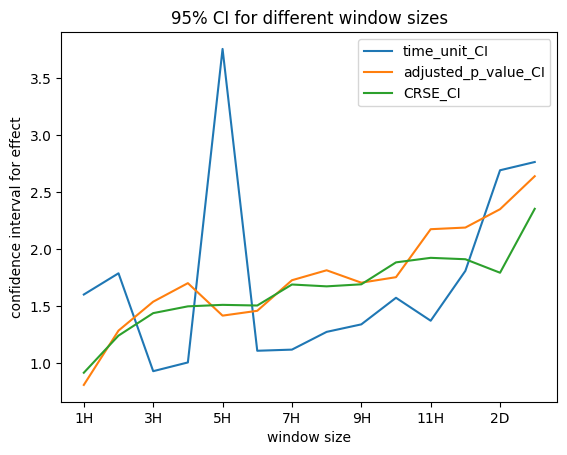

In [33]:
# for 95% CI multiply by 2
(results*2).plot()
plt.ylabel("confidence interval for effect")
plt.xlabel("window size")
plt.title("95% CI for different window sizes")

Text(0.5, 1.0, '95% CI (in %) for different window sizes')

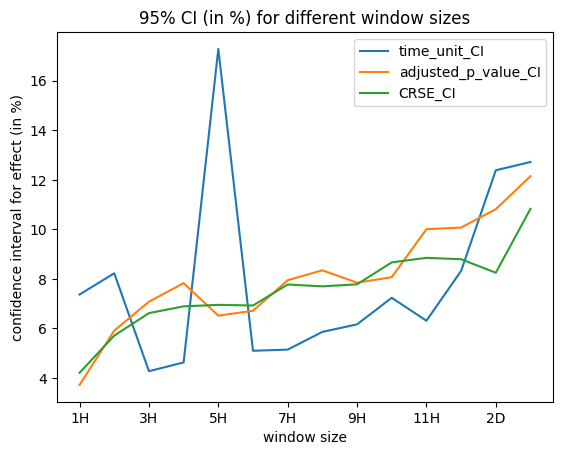

In [34]:
# in percent of mean
(100*(results*2)/data['delivery_time'].mean()).plot()
plt.ylabel("confidence interval for effect (in %)")
plt.xlabel("window size")
plt.title("95% CI (in %) for different window sizes")

# Check confidence interval coverage

In [35]:
data['time_unit'] = data['order_placed_at'].dt.floor("3H")

In [36]:
def check_coverage(CI_function, n_iterations):
    """Checks coverage of the CI_functions. Should be 68% (in one std)."""
    covered = 0
    for i in tqdm(range(n_iterations)):
        randomize_time_unit_assignment(data)
        CI, effect = CI_function(data, "delivery_time")
        if abs(effect)-CI < 0:
            covered += 1
    return percentage_metric(covered/n_iterations, n_iterations)

In [37]:
check_coverage(time_unit_CI, 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.19it/s]


0.68+-0.029502542263337237

In [38]:
check_coverage(CRSE_CI, 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:46<00:00,  1.01s/it]


0.671+-0.029715921658262593

# How does the variance change if we do not affect all order with surge?

In surging, we might not affect all orders but only a certain ratio. This will lead to higher variance and therefore a higher confidence interval (see image below). We show in this section that for realistic changes the increase in variance does not play a role.

In [206]:
randomize_time_unit_assignment(data)
ratio_affected = 0.2
data['affected'] = np.random.binomial(1, ratio_affected, len(data))
data["delivery_time_simulated"] = np.where((data['affected']==1) & (data['group']=='B'), 
                                           data['delivery_time']+100, data['delivery_time'])

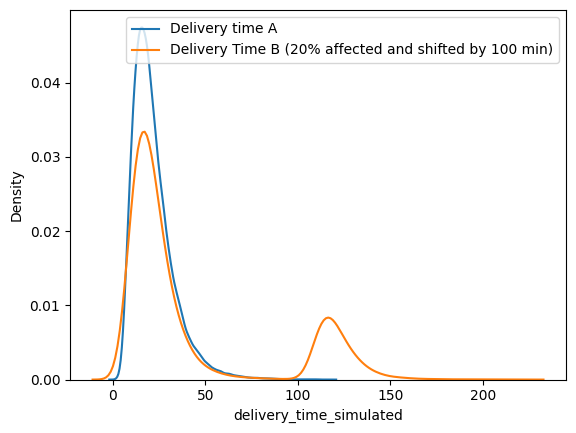

In [209]:
sns.kdeplot(data[data['group']=='A']['delivery_time_simulated'])
sns.kdeplot(data[data['group']=='B']['delivery_time_simulated'])
plt.legend(["Delivery time A", "Delivery Time B (20% affected and shifted by 100 min)"])

In [210]:
CIs = []
for ratio_affected in tqdm(np.arange(0,1.1,0.1)):
    data['affected'] = np.random.binomial(1, ratio_affected, len(data))
    data["delivery_time_simulated"] = np.where(data['affected']==1, data['delivery_time']+100, data['delivery_time'])
    CI, _ = CRSE_CI(data, "delivery_time_simulated")
    CIs.append(CI)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.05s/it]


Text(0.5, 1.0, 'x% of group affected by 100 minutes leads to confidence interval of...')

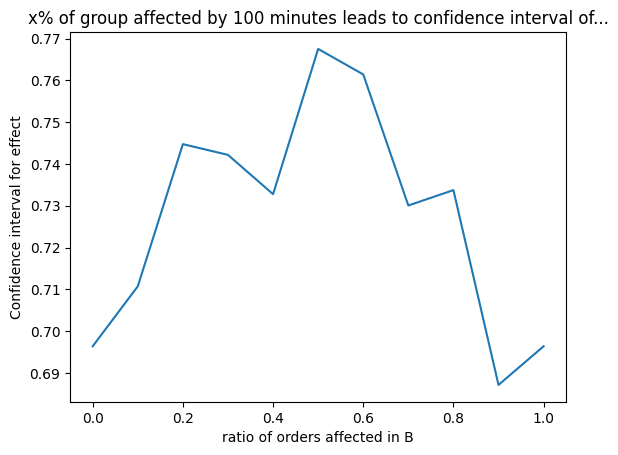

In [214]:
plt.plot(np.arange(0,1.1,0.1), CIs)
plt.xlabel("ratio of orders affected in B")
plt.ylabel("Confidence interval for effect")
plt.title("x% of group affected by 100 minutes leads to confidence interval of...")

In [215]:
CIs = []
for ratio_affected in tqdm(np.arange(0,1.1,0.1)):
    data['affected'] = np.random.binomial(1, ratio_affected, len(data))
    data["delivery_time_simulated"] = np.where(data['affected']==1, data['delivery_time']-10, data['delivery_time'])
    CI, _ = CRSE_CI(data, "delivery_time_simulated")
    CIs.append(CI)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.05s/it]


Text(0.5, 1.0, 'x% of group affected by 10 minutes leads to confidence interval of...')

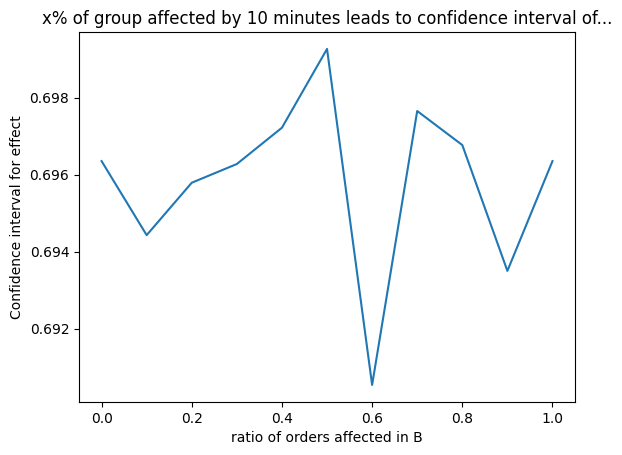

In [216]:
plt.plot(np.arange(0,1.1,0.1), CIs)
plt.xlabel("ratio of orders affected in B")
plt.ylabel("Confidence interval for effect")
plt.title("x% of group affected by 10 minutes leads to confidence interval of...")

# Notes

In [ ]:
#notes:

# calculate CI on country and city wide tests

# how many percent of the orders get the "surge treatment"?
# how many percent of the orders are actually affected by surge
# consider minumum window size "surge cycle"
# have you filtered outliers?
# do we have to consider speed of calculation?
# mutiple switchback tests active
# we are increasing natural fluctuations in switchback tests
# delta method?
# similar zones or cities counterpart

In [ ]:
# things that power depends on:

# sample size
# natural fluctuations between A and A'. Pick groups as similar as possible
# natural fluctuations are increased if we switchback test (do we need to limit them)
# window size as they also have different natural fluctuations
